In [69]:
# 데이터 처리 및 분석
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import warnings

# 시각화
import matplotlib.pyplot as plt
import seaborn as sns

# 통계 분석
from scipy import stats
from scipy.stats import shapiro, levene, ttest_ind, chi2_contingency, f_oneway
from scipy.stats import mannwhitneyu, fisher_exact, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
import pingouin as pg
import scikit_posthocs as sp

# 출력 설정
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# 한글 폰트 설정
import platform
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = 'AppleGothic'
else:  # Linux
    plt.rcParams['font.family'] = 'NanumGothic'

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (12, 6)

# 시드 설정
np.random.seed(42) # 팀원간의 결과물이 동일하게 보일 수 있음

print("="*60)
print("라이브러리 로드 완료!")
print("한글 폰트 설정 완료!")
print("="*60)

라이브러리 로드 완료!
한글 폰트 설정 완료!


In [70]:
import os
os.chdir(r"C:\Users\lizzy\OneDrive\바탕 화면\실전프로젝트\code\eda")  # 작업 디렉토리로 변경
print(os.getcwd())  # 잘 바뀌었는지 확인

C:\Users\lizzy\OneDrive\바탕 화면\실전프로젝트\code\eda


In [71]:
import pandas as pd

df_ict = pd.read_csv('ICT착유기.csv', encoding='utf-8')
df_robot = pd.read_csv('로봇착유기.csv', encoding='utf-8')
df_fatcontent = pd.read_csv('유성분검사성적서.csv', encoding='utf-8')
df_environment = pd.read_csv('환경관리기.csv', encoding='utf-8')


In [93]:
df_environment.shape

(28309, 9)

In [91]:
df_environment.columns

Index(['No', '지역', '규모', '농가명', '장비종류', '제조사아이디', '장비번호', '측정일시',
       '측정값(℃ · % · ppm)'],
      dtype='object')

In [ ]:
# 농장 ID 컬럼 이름이 동일하다고 가정 ('농장ID')
common_ids = set(df_fatcontent['농장ID']) & set(df_robot['농장ID'])

print(f"공통 농장 ID 개수: {len(common_ids)}")
print(f"공통 농장 ID 목록: {list(common_ids)}")


In [72]:
df_robot.shape

(732660, 25)

In [73]:
df_robot.columns

Index(['농장아이디', '개체번호', '축산업등록번호', '축종코드', '제조사 아이디', '장비코드', '장비번호', '측정일시',
       '착유량', '착유시작일시', '착유종료일시', '착유회차', '전도도', '체세포', '혈액흐름', '색상', '온도',
       '유지방', '유단백', '공기흐름', '수집구분', '수집일자', '수집건수', '산차', '반추시간'],
      dtype='object')

In [74]:
df_robot.isnull().sum() 

농장아이디           0
개체번호            0
축산업등록번호    732660
축종코드            0
제조사 아이디         0
장비코드       732660
장비번호       732660
측정일시            0
착유량             0
착유시작일시        286
착유종료일시        286
착유회차        48495
전도도           286
체세포        655288
혈액흐름        48781
색상         702770
온도          48783
유지방         38198
유단백         38198
공기흐름        48783
수집구분       732660
수집일자            0
수집건수            0
산차         477919
반추시간       684165
dtype: int64

(732660, 25)인 테이블에서 축산업등록번호, 장비코드, 장비번호, 수집구분 컬럼의 모든 행 결측값
거의 모두 결측값: 체세포, 색상(), 산차, 반추시간
결측값이 90% 이상(680,000+): 색상, 반추시간 -> 제거 또는 보류
결측값이 약 90%(655,288): 체세포 -> 보류 또는 예측 기반 대체
결측값이 약 65%(477,919):	산차	->	중요 변수 → 예측 기반 대체 고려
결측값이 약 6~7%(48,000~49,000): 착유회차, 혈액흐름, 온도, 공기흐름 -> 평균/중앙값 또는 회귀 대체
결측값이 약 5%(38,198):	유지방, 유단백 ->중요 변수 → 평균/중앙값 대체
결측값이 매우 낮음(286):	착유시작일시, 착유종료일시, 전도도	->	행 제거 또는 대체

In [75]:
# 테이블 복사본 생성
df_robot_copy = df_robot.copy()

# 지정한 컬럼들 제거
df_robot_copy.drop(columns=["축산업등록번호", "장비코드", "장비번호", "수집구분"], inplace=True)

# 결과 확인
print(df_robot_copy.head())


   농장아이디            개체번호 축종코드       제조사 아이디                   측정일시  착유량  \
0  20278  20120112010022  D00  agrirobotech  2020-01-20 00:00:00.0   24   
1  20278  20120112010022  D00  agrirobotech  2020-01-21 00:00:00.0   28   
2  20278  20120112010022  D00  agrirobotech  2020-01-22 00:00:00.0   37   
3  20278  20120112010022  D00  agrirobotech  2020-01-23 00:00:00.0   43   
4  20278  20120112010022  D00  agrirobotech  2020-01-24 00:00:00.0   43   

                  착유시작일시                 착유종료일시  착유회차    전도도  체세포 혈액흐름  색상  \
0  2020-01-20 00:00:00.0  2020-01-20 00:00:00.0   NaN  55.75  NaN  NaN NaN   
1  2020-01-21 00:00:00.0  2020-01-21 00:00:00.0   NaN  54.00  NaN  NaN NaN   
2  2020-01-22 00:00:00.0  2020-01-22 00:00:00.0   NaN  55.25  NaN  NaN NaN   
3  2020-01-23 00:00:00.0  2020-01-23 00:00:00.0   NaN  56.50  NaN  NaN NaN   
4  2020-01-24 00:00:00.0  2020-01-24 00:00:00.0   NaN  56.00  NaN  NaN NaN   

   온도  유지방  유단백  공기흐름      수집일자  수집건수   산차   반추시간  
0 NaN  NaN  NaN   NaN  20200

In [76]:
print(df_robot_copy['농장아이디'].unique())  # 농장 아이디의 고유값 개수 확인
print(df_robot_copy['개체번호'].unique())  # 농장 아이디의 고유값 개수 확인
print(df_robot_copy['축종코드'].unique())  # 농장 아이디의 고유값 개수 확인
print(df_robot_copy['제조사 아이디'].unique())  # 농장 아이디의 고유값 개수 확인
print(df_robot_copy['수집건수'].unique())  # 농장 아이디의 고유값 개수 확인

[20278 20338 20261 20279 20332 21133 20336 20264 21148 23021 20265]
[20120112010022 20120423010010 20130126010057 20130528010023
 20130609010024 20130816010079 20140113010011 20140417010025
 20140918010026 20140925010027 20140930010028 20140930010029
 20141014010030 20141030010031 20141102010013 20141110010058
 20150114010059 20150128010060 20150216010014 20150218010032
 20150228010033 20150324010034 20150821010061 20150829010017
 20150902010021 20160105010076 20160120010035 20160218010064
 20160308010080 20160413010065 20160403010040 20160606010066
 20160620010041 20160809010036 20160813010037 20160814010063
 20160819010038 20160824010039 20160924010050 20161118010073
 20170317010042 20170317010043 20170317010067 20170325010044
 20170416010045 20170425010046 20170607010047 20170709010048
 20170710010068 20170715010049 20170713010069 20170821010051
 20170924010070 20170925010082 20171004010071 20171010010072
 20171011010083 20171110010052 20171104010077 20171123010053
 20180202010054 2

In [90]:
df_robot_copy['착유회차'].unique()

array([nan,  1.,  2.,  3.,  4.,  5.,  6.])

In [77]:
df_robot_copy.duplicated().sum()

np.int64(0)

In [78]:
df_robot_copy['착유시작일시'] = pd.to_datetime(df_robot_copy['착유시작일시'])
df_robot_copy['착유종료일시'] = pd.to_datetime(df_robot_copy['착유종료일시'])
df_robot_copy['측정일시'] = pd.to_datetime(df_robot_copy['측정일시'])


In [79]:
# '착유시작일시', '착유종료일시' 컬럼이 다른지 비교
all_equal = (df_robot_copy['착유시작일시'] != df_robot_copy['착유종료일시'])

# 모든 행이 True인지 확인
df_robot_copy.loc[all_equal]



,농장아이디,개체번호,축종코드,제조사 아이디,측정일시,착유량,착유시작일시,착유종료일시,착유회차,전도도,체세포,혈액흐름,색상,온도,유지방,유단백,공기흐름,수집일자,수집건수,산차,반추시간
15350,20338,20151223020088,D00,agrirobotech,2020-05-22 00:27:30,14,2020-05-22 00:27:30,2020-05-22 00:32:05,1.0,6.2,NaN,N,NaN,39.6,3.3,3.0,6.3,20200617,1,NaN,NaN
15351,20261,20151223010018,D00,agrirobotech,2020-05-22 00:27:30,14,2020-05-22 00:27:30,2020-05-22 00:32:05,1.0,6.2,NaN,N,NaN,39.6,3.3,3.0,6.3,20200617,1,NaN,NaN
15352,20338,20151223020088,D00,agrirobotech,2020-05-22 07:23:45,10,2020-05-22 07:23:45,2020-05-22 07:29:20,2.0,6.2,NaN,N,NaN,39.4,3.7,3.0,2.9,20200617,1,NaN,NaN
15353,20261,20151223010018,D00,agrirobotech,2020-05-22 07:23:45,10,2020-05-22 07:23:45,2020-05-22 07:29:20,2.0,6.2,NaN,N,NaN,39.4,3.7,3.0,2.9,20200617,1,NaN,NaN
15354,20338,20151223020088,D00,agrirobotech,2020-05-22 15:21:22,13,2020-05-22 15:21:22,2020-05-22 15:26:08,3.0,6.3,NaN,N,NaN,39.6,3.2,3.0,4.5,20200617,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
732655,20265,20190414010099,D00,agrirobotech,2022-11-08 12:46:46,9,2022-11-08 12:46:46,2022-11-08 12:53:05,2.0,6.6,NaN,N,NaN,39.4,4.6,3.4,3.3,20221109,1,1.0,NaN
732656,20265,20190414010099,D00,agrirobotech,2022-11-09 01:26:34,9,2022-11-09 01:26:34,2022-11-09 01:32:17,1.0,6.6,NaN,N,NaN,38.6,4.2,3.4,2.9,20221110,1,1.0,NaN
732657,20265,20190414010099,D00,agrirobotech,2022-11-09 09:41:34,6,2022-11-09 09:41:34,2022-11-09 09:47:14,2.0,6.6,NaN,N,NaN,38.3,4.5,3.4,2.1,20221110,1,1.0,NaN
732658,20265,20190414010099,D00,agrirobotech,2022-11-09 21:26:42,9,2022-11-09 21:26:42,2022-11-09 21:32:39,3.0,6.5,NaN,N,NaN,39.7,4.4,3.4,3.2,20221110,1,1.0,NaN


In [80]:
# 세 컬럼이 모두 같은지 비교
all_equal = (df_robot_copy['착유시작일시'] != df_robot_copy['측정일시'])

# 모든 행이 True인지 확인
df_robot_copy.loc[all_equal]

,농장아이디,개체번호,축종코드,제조사 아이디,측정일시,착유량,착유시작일시,착유종료일시,착유회차,전도도,체세포,혈액흐름,색상,온도,유지방,유단백,공기흐름,수집일자,수집건수,산차,반추시간
490875,21148,20190320020080,D00,delaval,2022-03-29 13:23:00,21,NaT,NaT,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20220329,1,1.0,NaN
490876,23021,20190320020089,D00,delaval,2022-03-29 13:23:00,21,NaT,NaT,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20220329,1,1.0,NaN
490877,21148,20190320020080,D00,delaval,2022-03-30 13:23:00,27,NaT,NaT,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20220330,1,1.0,NaN
490878,23021,20190320020089,D00,delaval,2022-03-30 13:23:00,27,NaT,NaT,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20220330,1,1.0,NaN
490879,21148,20190320020080,D00,delaval,2022-03-31 13:23:00,13,NaT,NaT,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20220331,1,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491156,23021,20190320020089,D00,delaval,2022-12-29 13:23:01,32,NaT,NaT,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20221229,1,2.0,NaN
491157,21148,20190320020080,D00,delaval,2022-12-30 13:23:01,27,NaT,NaT,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20221230,1,2.0,NaN
491158,23021,20190320020089,D00,delaval,2022-12-30 13:23:01,27,NaT,NaT,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20221230,1,2.0,NaN
491159,23021,20190320020089,D00,delaval,2022-12-31 13:23:01,25,NaT,NaT,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20221231,1,2.0,NaN


## 결측값이 90% 이상(680,000+): 색상, 반추시간 -> 제거 또는 보류

In [81]:
df_robot_copy['색상'].value_counts()

색상
0.0    29890
Name: count, dtype: int64

색상은 제외시키기! 거의가 결측값이고, 남은 약 30000개의 컬럼이 의미를 알 수 없는 0.0

In [82]:
df_robot_copy['반추시간'].value_counts()

반추시간
488.0    263
554.0    259
553.0    258
474.0    252
542.0    252
        ... 
210.0      1
162.0      1
86.0       1
149.0      1
140.0      1
Name: count, Length: 631, dtype: int64

In [83]:
df_robot_copy.drop(columns=['색상'], inplace=True)

In [84]:
df_filtered = df_robot_copy[df_robot_copy['반추시간'].isna()]
df_filtered.head(30)

,농장아이디,개체번호,축종코드,제조사 아이디,측정일시,착유량,착유시작일시,착유종료일시,착유회차,전도도,체세포,혈액흐름,온도,유지방,유단백,공기흐름,수집일자,수집건수,산차,반추시간
15350,20338,20151223020088,D00,agrirobotech,2020-05-22 00:27:30,14,2020-05-22 00:27:30,2020-05-22 00:32:05,1.0,6.2,NaN,N,39.6,3.3,3.0,6.3,20200617,1,NaN,NaN
15351,20261,20151223010018,D00,agrirobotech,2020-05-22 00:27:30,14,2020-05-22 00:27:30,2020-05-22 00:32:05,1.0,6.2,NaN,N,39.6,3.3,3.0,6.3,20200617,1,NaN,NaN
15352,20338,20151223020088,D00,agrirobotech,2020-05-22 07:23:45,10,2020-05-22 07:23:45,2020-05-22 07:29:20,2.0,6.2,NaN,N,39.4,3.7,3.0,2.9,20200617,1,NaN,NaN
15353,20261,20151223010018,D00,agrirobotech,2020-05-22 07:23:45,10,2020-05-22 07:23:45,2020-05-22 07:29:20,2.0,6.2,NaN,N,39.4,3.7,3.0,2.9,20200617,1,NaN,NaN
15354,20338,20151223020088,D00,agrirobotech,2020-05-22 15:21:22,13,2020-05-22 15:21:22,2020-05-22 15:26:08,3.0,6.3,NaN,N,39.6,3.2,3.0,4.5,20200617,1,NaN,NaN
15355,20261,20151223010018,D00,agrirobotech,2020-05-22 15:21:22,13,2020-05-22 15:21:22,2020-05-22 15:26:08,3.0,6.3,NaN,N,39.6,3.2,3.0,4.5,20200617,1,NaN,NaN
15356,20338,20151223020088,D00,agrirobotech,2020-05-22 23:39:21,12,2020-05-22 23:39:21,2020-05-22 23:44:32,4.0,6.5,NaN,N,39.3,2.9,3.0,3.9,20200617,1,NaN,NaN
15357,20261,20151223010018,D00,agrirobotech,2020-05-22 23:39:21,12,2020-05-22 23:39:21,2020-05-22 23:44:32,4.0,6.5,NaN,N,39.3,2.9,3.0,3.9,20200617,1,NaN,NaN
15358,20338,20151223020088,D00,agrirobotech,2020-05-23 06:14:27,11,2020-05-23 06:14:27,2020-05-23 06:19:21,1.0,6.2,NaN,N,39.0,3.3,3.0,3.7,20200617,1,NaN,NaN
15359,20261,20151223010018,D00,agrirobotech,2020-05-23 06:14:27,11,2020-05-23 06:14:27,2020-05-23 06:19:21,1.0,6.2,NaN,N,39.0,3.3,3.0,3.7,20200617,1,NaN,NaN


반추시간은 진짜 어떻게 해야할까?
🐄 반추시간(Rumination Time) 개요
단위: 분 (minutes)

정의: 젖소가 되새김질을 하는 총 시간. 위가 4개인 젖소가 풀사료를 씹고 되삼키는 소화 과정

측정 방식: IoT 센서(목걸이형 등)를 통해 자동 수집

📊 평균 반추시간
정상적인 젖소: 하루 평균 450~550분

우유 생산량이 많은 젖소: 반추시간이 더 길어지는 경향 (예: ≥41kg/일 생산 시 약 500분 이상)

더위 등 스트레스 상황: 반추시간이 감소 (예: 폭염 시 380분까지 감소)

🧠 반추시간과 우유 생산의 관계
🌟반추시간이 길수록 사료 소화율과 섭취량이 증가 → 우유 생산량 증가

🌟반추시간이 짧아지면 스트레스, 질병, 사료 문제를 의심할 수 있음

🌟질병 의심군 분류에 매우 유용한 생리 지표

IQR 기준 이상치 개수: 563
lower_bound: 298.0
upper_bound: 738.0


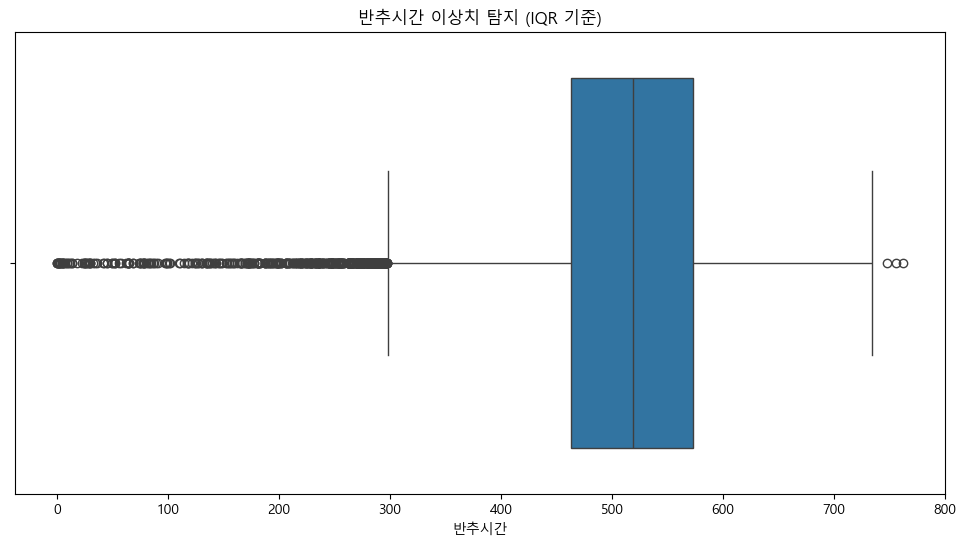

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt
# 1. IQR 계산
Q1 = df_robot_copy['반추시간'].quantile(0.25)
Q3 = df_robot_copy['반추시간'].quantile(0.75)
IQR = Q3 - Q1

# 2. 이상치 기준 설정
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 3. 이상치 탐지
outliers = df_robot_copy[
    (df_robot_copy['반추시간'] < lower_bound) |
    (df_robot_copy['반추시간'] > upper_bound)
]

# 4. 결과 출력
print(f"IQR 기준 이상치 개수: {len(outliers)}")
print(f"lower_bound: {lower_bound}")
print(f"upper_bound: {upper_bound}")


sns.boxplot(x=df_robot_copy['반추시간'])
plt.title("반추시간 이상치 탐지 (IQR 기준)")
plt.show()



## 결측값이 약 90%(655,288): 체세포 -> 보류 또는 예측 기반 대체

IQR 기준 이상치 개수: 5890
lower_bound: -132.0
upper_bound: 220.0


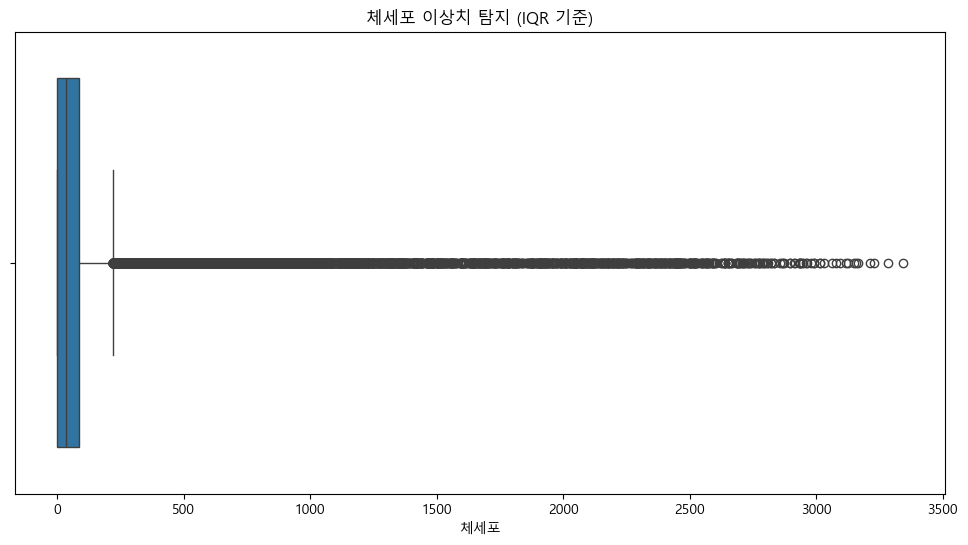

In [86]:
# 1. IQR 계산
Q1 = df_robot_copy['체세포'].quantile(0.25)
Q3 = df_robot_copy['체세포'].quantile(0.75)
IQR = Q3 - Q1

# 2. 이상치 기준 설정
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 3. 이상치 탐지
outliers = df_robot_copy[
    (df_robot_copy['체세포'] < lower_bound) |
    (df_robot_copy['체세포'] > upper_bound)
]

# 4. 결과 출력
print(f"IQR 기준 이상치 개수: {len(outliers)}")
print(f"lower_bound: {lower_bound}")
print(f"upper_bound: {upper_bound}")

sns.boxplot(x=df_robot_copy['체세포'])
plt.title("체세포 이상치 탐지 (IQR 기준)")
plt.show()

In [87]:
df_robot_copy.loc[df_robot_copy['체세포'] <= 0]


,농장아이디,개체번호,축종코드,제조사 아이디,측정일시,착유량,착유시작일시,착유종료일시,착유회차,전도도,체세포,혈액흐름,온도,유지방,유단백,공기흐름,수집일자,수집건수,산차,반추시간
15506,20261,20151223010018,D00,agrirobotech,2020-07-08 06:01:07,12,2020-07-08 06:01:07,2020-07-08 06:05:23,1.0,6.4,0.0,N,39.4,3.5,3.0,5.5,20200709,1,NaN,NaN
15507,20338,20151223020088,D00,agrirobotech,2020-07-08 06:01:07,12,2020-07-08 06:01:07,2020-07-08 06:05:23,1.0,6.4,0.0,N,39.4,3.5,3.0,5.5,20200709,1,NaN,NaN
15508,20338,20151223020088,D00,agrirobotech,2020-07-08 12:16:58,9,2020-07-08 12:16:58,2020-07-08 12:22:00,2.0,6.4,0.0,N,39.4,3.7,2.9,2.9,20200709,1,NaN,NaN
15509,20261,20151223010018,D00,agrirobotech,2020-07-08 12:16:58,9,2020-07-08 12:16:58,2020-07-08 12:22:00,2.0,6.4,0.0,N,39.4,3.7,2.9,2.9,20200709,1,NaN,NaN
15510,20338,20151223020088,D00,agrirobotech,2020-07-08 21:07:58,13,2020-07-08 21:07:58,2020-07-08 21:11:52,3.0,6.4,0.0,N,39.4,3.1,3.0,6.3,20200709,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103383,20336,20150224020084,D00,agrirobotech,2020-08-11 07:52:52,29,2020-08-11 07:52:52,2020-08-11 08:04:57,1.0,6.7,0.0,N,39.8,0.0,0.0,2.9,20200812,1,NaN,NaN
103384,20336,20150224020084,D00,agrirobotech,2020-08-17 09:37:28,27,2020-08-17 09:37:28,2020-08-17 09:49:25,1.0,6.5,0.0,N,39.7,0.0,0.0,2.7,20200818,1,0.0,NaN
103385,20336,20150224020084,D00,agrirobotech,2020-08-18 01:20:10,27,2020-08-18 01:20:10,2020-08-18 01:32:59,1.0,6.4,0.0,N,40.0,0.0,0.0,2.7,20200819,1,0.0,NaN
103386,20336,20150224020084,D00,agrirobotech,2020-08-18 13:21:48,21,2020-08-18 13:21:48,2020-08-18 13:33:20,2.0,6.5,0.0,N,40.0,0.0,0.0,3.3,20200819,1,0.0,NaN


일반적으로 우유의 체세포 수가 정확히 0이 되는 경우는 거의 없습니다. 이론적으로는 가능하지만, 실제 축산 현장에서는 센서 오류, 데이터 누락, 또는 비정상적인 기록일 가능성이 높습니다.

In [88]:
count = (df_robot_copy['체세포'] <= 0).sum()
print(f"체세포 값이 0 이하인 행 개수: {count}")


체세포 값이 0 이하인 행 개수: 29890


In [89]:
체세포도 90%이상이 결측치나 다름없음...!

SyntaxError: invalid syntax (2351852539.py, line 1)

🧬 체세포란?
정의: 우유 속에 포함된 백혈구와 유방 상피세포의 수

🌟단위: 보통 개/mL 또는 ×10³ cells/mL

의미:

백혈구는 감염에 반응하는 면역세포

체세포 수가 많다는 건 유방염 등 질병 가능성을 의미

🌟정상 범위: 보통 100,000~200,000 cells/mL 이하가 양호한 상태로 간주됨
🌟체세포는 질병 의심군 분류에 핵심 지표입니다

체세포 수가 높으면:

우유 품질 저하 (맛, 유통기한, 가공 적합성)

생산량 감소 (염증으로 인한 착유량 저하)

따라서 이 컬럼은 매우 중요합니다

## 결측값이 약 65%(477,919):	산차	->	중요 변수 → 예측 기반 대체 고려


산차: 젖소의 생산성과 건강 상태를 평가하는 핵심 지표로, 우유 품질·생산량·번식력에 직접적인 영향을 미칩니다. 특히 질병 위험과 도태 시점 결정에 중요한 기준이 됩니다.**

---

## 🐄 산차란?
- **정의**: 젖소가 몇 번 분만했는지를 나타내는 지표 (예: 초산 = 1산차, 경산 = 2산차 이상)
- **의미**: 젖소의 생애주기, 생산 경험, 번식력, 건강 상태를 반영

---

## 🎯 산차가 중요한 이유

### 1. **우유 생산량과 품질에 영향**
- 일반적으로 **2~4산차 사이가 생산량과 품질이 가장 안정적**
- 초산(1산차)은 신체 미성숙으로 생산량이 낮고, 6산차 이상은 노화로 생산성 저하

### 2. **질병 위험과 도태 시점 판단**
- **산차가 높을수록** 유방염, 번식 장애, 체세포 수 증가 등 **질병 위험 증가**
- **6산차 이후**는 도태가 권장되는 시점으로, 경제적 효율이 낮아짐

### 3. **번식력과 생애 생산성**
- **2산차 증후군**: 초산 후 회복이 부족하면 2산차에서 번식력 저하 발생
- 번식력 저하 → 총산자수 감소 → 조기 도태 가능성 증가

---

## 📊 분석에 활용하는 방법

| 분석 목적 | 산차 활용 방식 |
|-----------|----------------|
| 질병 의심군 분류 | 고산차 + 체세포 수 증가 → 의심군 가능성 높음 |
| 생산 최적화 | 2~4산차 중심으로 생산량·품질 분석 |
| 도태 전략 | 6산차 이상은 생산성·건강 상태 평가 후 도태 고려 |

---

## 🧠 결론
- **산차는 제거하면 안 되는 핵심 변수**입니다.
- 질병 분류, 생산량 예측, 도태 전략 수립에 모두 활용되며, 결측값이 있다면 예측 기반 보간 또는 결측 여부 변수화가 필요합니다.

In [ ]:
count_1 = (df_robot_copy['산차'] < 0).sum()
print(f"산차 값이 0 이하인 행 개수: {count_1}")

체세포 값이 0 이하인 행 개수: 0


IQR 기준 이상치 개수: 4169
lower_bound: -2.0
upper_bound: 6.0


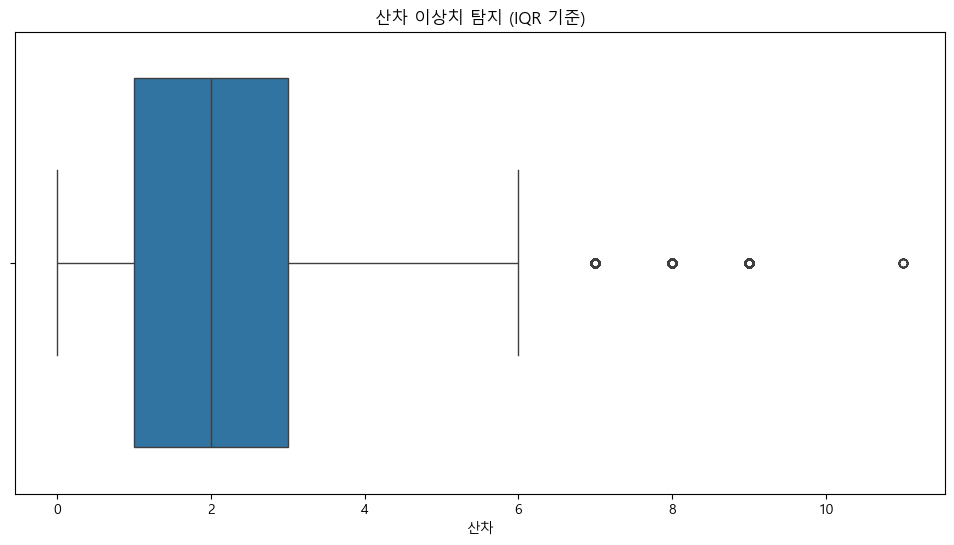

In [ ]:
# 1. IQR 계산
Q1 = df_robot_copy['산차'].quantile(0.25)
Q3 = df_robot_copy['산차'].quantile(0.75)
IQR = Q3 - Q1

# 2. 이상치 기준 설정
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 3. 이상치 탐지
outliers = df_robot_copy[
    (df_robot_copy['산차'] < lower_bound) |
    (df_robot_copy['산차'] > upper_bound)
]

# 4. 결과 출력
print(f"IQR 기준 이상치 개수: {len(outliers)}")
print(f"lower_bound: {lower_bound}")
print(f"upper_bound: {upper_bound}")

sns.boxplot(x=df_robot_copy['산차'])
plt.title("산차 이상치 탐지 (IQR 기준)")
plt.show()

실무 기준: 6~7산차 이상은 생산성 저하와 질병 위험으로 이상치 또는 도태 대상

### 결측값이 약 6~7%(48,000~49,000): 착유회차, 혈액흐름, 온도, 공기흐름 -> 평균/중앙값 또는 회귀 대체
### 결측값이 약 5%(38,198):	유지방, 유단백 ->중요 변수 → 평균/중앙값 대체
### 결측값이 매우 낮음(286):	착유시작일시, 착유종료일시, 전도도	->	행 제거 또는 대체

In [ ]:
df_robot_copy.dtypes


농장아이디               int64
개체번호                int64
축종코드               object
제조사 아이디            object
측정일시       datetime64[ns]
착유량                 int64
착유시작일시     datetime64[ns]
착유종료일시     datetime64[ns]
착유회차              float64
전도도               float64
체세포               float64
혈액흐름               object
온도                float64
유지방               float64
유단백               float64
공기흐름              float64
수집일자                int64
수집건수                int64
산차                float64
반추시간              float64
dtype: object

In [ ]:
df_robot_copy['혈액흐름'].unique()

array([nan, 'N', 'Y'], dtype=object)

In [ ]:
count_2 = (df_robot_copy['착유회차'] < 0).sum()
print(f"산차 값이 0 이하인 행 개수: {count_2}")

산차 값이 0 이하인 행 개수: 0


In [ ]:
df_robot_copy['착유회차'].value_counts()

착유회차
1.0    243961
2.0    224275
3.0    154638
4.0     55617
5.0      5646
6.0        28
Name: count, dtype: int64

In [ ]:
count_3 = (df_robot_copy['온도'] < 0).sum()
print(f"온도 값이 0 이하인 행 개수: {count_3}")

온도 값이 0 이하인 행 개수: 0


In [ ]:
df_robot_copy['온도'].value_counts()

온도
39.0    38164
39.1    37434
38.7    36075
38.0    35783
39.4    32903
        ...  
43.9        1
30.2        1
43.4        1
45.7        1
44.3        1
Name: count, Length: 175, dtype: int64